# PhD Work - Marine Heatwave Pipeline
The following will go through all the necessary steps to obtain useful information on marine heatwaves from sea surface temperature data using ACCESS-OM2-01 as the test case. 

#### NOTE: For `threshold` and `detect` use unstable environment

####       For `block_average` use `analysis3-22-04` or some other older environemnt

This is due to xarray's update causing problems with multi-indexing when unstacking cells back to lat/lon grid. 

In [1]:
# Load required modules
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy as sci
import dask
import cosima_cookbook as cc
import os

# Optional modules
import cmocean as cm

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41025/status,
Dashboard: /proxy/41025/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43621,Workers: 7
Dashboard: /proxy/41025/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:35409,Total threads: 2
Dashboard: /proxy/43105/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:36807,


In [3]:
print(client.ncores)

<bound method Client.nthreads of <Client: 'tcp://127.0.0.1:43621' processes=7 threads=14, memory=63.00 GiB>>


In [4]:
# directory setup
exp_name = 'mhws_noaa/'
parentdir = '/g/data/v45/jr5971/mhw-analysis/'
workdir = parentdir + exp_name

for i in [parentdir, workdir]:
    try: os.mkdir(workdir)
    except: pass

## Import SST Data

In [5]:
import glob

In [6]:
noaa_path = '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/*.nc'
file_list = glob.glob(noaa_path)

In [7]:
len(file_list)

43

In [8]:
file_list[:5]

['/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1992.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_2022.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_2018.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_2016.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_2005.nc']

In [9]:
file_list.sort()
newlist = []
i=0
while '1990' not in file_list[i]:
    i+=1
first=i
newlist = file_list[first:]
newlist[:5]

['/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1990.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1991.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1992.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1993.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1994.nc']

In [10]:
oisst = xr.open_mfdataset(newlist)

In [11]:
oisst

<xarray.Dataset>
Dimensions:  (time: 12044, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2023-03-23T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/40)
    CDI:                        Climate Data Interface version 2.0.5 (https:/...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    institution:                NOAA/National Centers for Environmental Infor...
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         oisst-avhrr-v02r01.19900101.nc
    ...                         ...
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    CDO:                        Climate Data Operators version 2.0.5 (https:/...
    NCO:                        netCDF Operators version 5.0.5 (Homepage = ht...
    history:                    Fri Sep 30 17:04:11 2022: ncatted -O -a histo...

In [12]:
oisst_anom = oisst['anom']
oisst_anom

<xarray.DataArray 'anom' (time: 12044, zlev: 1, lat: 720, lon: 1440)>
dask.array<concatenate, shape=(12044, 1, 720, 1440), dtype=float32, chunksize=(366, 1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2023-03-23T12:00:00
  * zlev     (zlev) float32 0.0
Attributes:
    long_name:  Daily sea surface temperature anomalies
    units:      Celsius

In [68]:
oisst.nbytes/1e9

199.795612196

Right so the 33 years of SST data takes up quite a large chunk of space - 200GB to be exact. 

Let's now subset to just the region of interest (Tasman Sea for now...)

In [69]:
from matplotlib import patches

In [13]:
eac_box = {'W':140, 'E':160, 'S':-48, 'N':-10}
oisst_eac = oisst.sel(lat=slice(eac_box['S'], eac_box['N']), lon=slice(eac_box['W'], eac_box['E']))
oisst_eac

<xarray.Dataset>
Dimensions:  (time: 12044, zlev: 1, lat: 152, lon: 80)
Coordinates:
  * lat      (lat) float32 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
  * lon      (lon) float32 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2023-03-23T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
Attributes: (12/40)
    CDI:                        Climate Data Interface version 2.0.5 (https:/...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    institution:                NOAA/National Centers for Environmental Infor...
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         oisst-avhrr-v02r01.19900101.nc
    ...                         ...
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    CDO:                        Climate Data Operators version 2.0.5 (https:/...
    NCO:                        netCDF Operators version 5.0.5 (Homepage = ht...
    history:                    Fri Sep 30 17:04:11 2022: ncatted -O -a histo...

In [15]:
oissta_eac = oisst_eac['anom'].squeeze()
oissta_eac

<xarray.DataArray 'anom' (time: 12044, lat: 152, lon: 80)>
dask.array<getitem, shape=(12044, 152, 80), dtype=float32, chunksize=(366, 152, 80), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
  * lon      (lon) float32 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2023-03-23T12:00:00
    zlev     float32 0.0
Attributes:
    long_name:  Daily sea surface temperature anomalies
    units:      Celsius

In [16]:
oissta_eac.to_netcdf('/g/data/v45/jr5971/notebooks/data/oissta_eac.nc')

CPU times: user 690 ms, sys: 81 ms, total: 771 ms
Wall time: 5 s


(-50.0, 0.0)

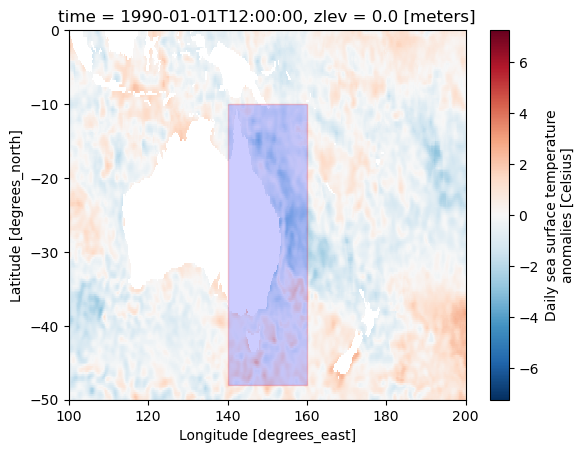

In [71]:
%%time
fig = plt.figure()
ax = fig.add_subplot()
oisst = oisst.squeeze()
oisst['anom'].isel(time=0).plot(ax=ax)

eac_rect = patches.Rectangle((eac_box['W'],eac_box['S']),(eac_box['E']-eac_box['W']),
                             (eac_box['N']-eac_box['S']), edgecolor='r',facecolor='b', alpha=0.2)
ax.add_patch(eac_rect)

plt.xlim(100, 200); plt.ylim(-50, 0)

Right, so we've now got our domain of interest for calculating MHWs. Let's save the temperature data from this, and then step through the MHW process..

In [74]:
sst = oisst_eac['sst'] - 273.15

sst.to_netcdf('/g/data/v45/jr5971/notebooks/data/oisst_eac.nc')

Let's try the MHW code and see how long it takes - perhaps on the 16-core session though..

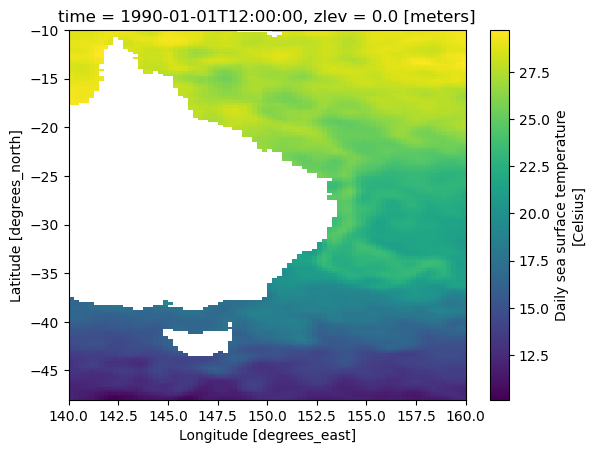

In [76]:
oisst_eac['sst'].isel(time=0).plot()

## First look at the NOAA MHW Results!

In [7]:
import glob

In [8]:
mhws_path = '/g/data/v45/jr5971/mhw-analysis/mhws_noaa/temp_res/'
clim_files = glob.glob(mhws_path + 'th_res_*.nc')
detect_files = glob.glob(mhws_path + 'det_res_*.nc')
clim_files.sort()
detect_files[:5]

['/g/data/v45/jr5971/mhw-analysis/mhws_noaa/temp_res/det_res_33.nc',
 '/g/data/v45/jr5971/mhw-analysis/mhws_noaa/temp_res/det_res_22.nc',
 '/g/data/v45/jr5971/mhw-analysis/mhws_noaa/temp_res/det_res_31.nc',
 '/g/data/v45/jr5971/mhw-analysis/mhws_noaa/temp_res/det_res_15.nc',
 '/g/data/v45/jr5971/mhw-analysis/mhws_noaa/temp_res/det_res_9.nc']

In [ ]:
interm_files = glob.glob(mhws_path + 'int_res_*.nc')
interm_files

In [10]:
interm = xr.open_mfdataset(interm_files, combine='nested', concat_dim=('lat')).sortby('lat')
interm

<xarray.Dataset>
Dimensions:            (lon: 80, time: 12040, lat: 152)
Coordinates:
  * lon                (lon) float32 140.1 140.4 140.6 ... 159.4 159.6 159.9
  * time               (time) datetime64[ns] 1990-01-01T12:00:00 ... 2023-03-...
  * lat                (lat) float32 -47.88 -47.62 -47.38 ... -10.38 -10.12
Data variables: (12/15)
    ts                 (time, lat, lon) float32 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    seas               (time, lat, lon) float32 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    thresh             (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    bthresh            (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    events             (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    relSeas            (time, lat, lon) float32 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    ...                 ...
    cats               (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    duration_moderate  (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    duration_strong    (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    duration_severe    (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    duration_extreme   (time, lat, lon) float64 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>
    mabs               (time, lat, lon) float32 dask.array<chunksize=(12040, 4, 80), meta=np.ndarray>

In [11]:
clim = xr.open_mfdataset(clim_files, combine='nested', concat_dim=('lat'))
clim = clim.sortby('lat')
clim

<xarray.Dataset>
Dimensions:   (lon: 80, doy: 366, lat: 152)
Coordinates:
  * lon       (lon) float32 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
  * lat       (lat) float32 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
    quantile  float64 0.9
Data variables:
    thresh    (doy, lat, lon) float64 dask.array<chunksize=(366, 4, 80), meta=np.ndarray>
    seas      (doy, lat, lon) float32 dask.array<chunksize=(366, 4, 80), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2023-03-23: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

In [12]:
mhws = xr.open_mfdataset(detect_files, concat_dim='lat', combine='nested').sortby('lat')
mhws

<xarray.Dataset>
Dimensions:                         (lon: 80, events: 10686, lat: 152)
Coordinates:
  * lon                             (lon) float64 140.1 140.4 ... 159.6 159.9
  * events                          (events) float64 1.0 2.0 ... 1.204e+04
  * lat                             (lat) float64 -47.88 -47.62 ... -10.12
Data variables: (12/31)
    event                           (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    index_start                     (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    index_end                       (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    time_start                      (events, lat, lon) datetime64[ns] dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    time_end                        (events, lat, lon) datetime64[ns] dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    time_peak                       (events, lat, lon) datetime64[ns] dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    ...                              ...
    intensity_var_relThresh         (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    intensity_var_abs               (events, lat, lon) float32 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    category                        (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    duration                        (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    rate_onset                      (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
    rate_decline                    (events, lat, lon) float64 dask.array<chunksize=(10686, 4, 80), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-03-23: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

## Update after coming back to this many months later
So, it's great that I've been able to keep those results of OISST. One quick question - does the new EAC-003 domain fit inside that originally chosen for OISST?

In [16]:
# Index of EAC-003
eac_path = '/scratch/v45/jr5971/mom6-setonix/eac_iaf_003/'
eac_snapshot = xr.open_dataset(glob.glob(eac_path+'output000/*ocean_daily.nc')[0])
eac_idx = {'W':eac_snapshot.xh.min().values, 'E':eac_snapshot.xh.max().values,
           'S':eac_snapshot.yh.min().values, 'N':eac_snapshot.yh.max().values}
eac_idx

{'W': array(-217.78333333),
 'E': array(-198.01666667),
 'S': array(-46.17862959),
 'N': array(-14.07299099)}

In [19]:
# OISST Index...
oisst_idx = {'W':mhws.lon.min().values-360, 'E':mhws.lon.max().values-360,
            'S':mhws.lat.min().values, 'N':mhws.lat.max().values}
oisst_idx

{'W': -219.875, 'E': -200.125, 'S': array(-47.875), 'N': array(-10.125)}

Might be easier to plot the two datasets to see how much overlap there is...

In [23]:
from matplotlib import patches

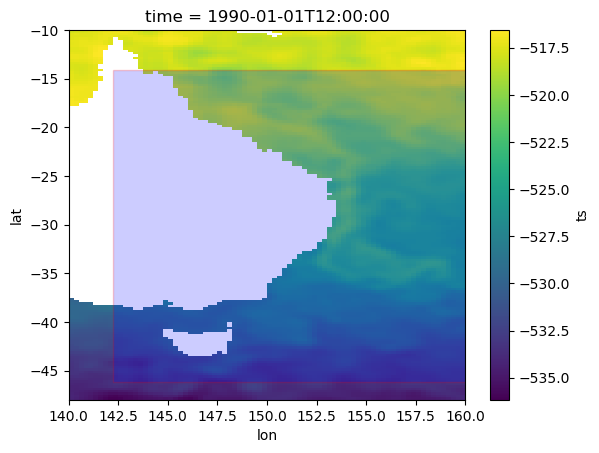

In [25]:
fig, ax = plt.subplots()

interm['ts'].isel(time=0).plot(ax=ax)

eac_rect = patches.Rectangle((eac_idx['W']+360,eac_idx['S']),(eac_idx['E']-eac_idx['W']+360),
                             (eac_idx['N']-eac_idx['S']), edgecolor='r',facecolor='b', alpha=0.2)
ax.add_patch(eac_rect)

Okay, so there's our answer - most of the EAC-003 domain is within the OISST mhw results apart from a small section to the east which isn't of a great deal of interest anyway. 

So what now? It'd be good to get the mhw results for the SOUTHPAC domain. For this, we'd just set up something similar to what we did for the OISST back in the day. 

Apart from that, I should also do the same for the ACCESS data - after subsetting the domain boundaries of course. Then, once I've got the completed run for the EAC-003, I can do the same for that - which will no doubt take a lot longer. 

Now - once I have all this output, will that add value to the model evaluation? My immediate thoughts are that it will most definitely, as it should likely show the large MHWs that move poleward along the EAC extension. It could be cool to do a Hovmoller similar to the Malan paper along a SW-NE transect that shows the MHW propagating poleward. Overall, I want to show in this paper that although the mean temperature is different, the variability is similar...

What about some PDFs? Are the variance/std-dev spatial maps not a similar indicator to the PDFs? 

Right, so now to our initial question - what was the longest lasting MHW over the record?

In [22]:
dur = mhws['duration']
dur

<xarray.DataArray 'duration' (events: 10686, lat: 152, lon: 80)>
dask.array<getitem, shape=(10686, 152, 80), dtype=float64, chunksize=(10686, 4, 80), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
  * events   (events) float64 1.0 2.0 3.0 4.0 ... 1.203e+04 1.203e+04 1.204e+04
  * lat      (lat) float64 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
Attributes:
    long_name:  MHW duration in number of days
    units:      1

So, the events dimension represents the starting point of each event. Let's select one grid point to see more about the `events` dimension structure...

In [23]:
mhw_point = mhws.sel(lat=-42, lon=150, method='nearest')
mhw_point.events

<xarray.DataArray 'events' (events: 10686)>
array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.2033e+04, 1.2034e+04,
       1.2035e+04])
Coordinates:
    lon      float64 150.1
  * events   (events) float64 1.0 2.0 3.0 4.0 ... 1.203e+04 1.203e+04 1.204e+04
    lat      float64 -41.88

Note however that not all the events will be occurring at the selected gridpoint. We can see that by having a look at the `index_start` or `time_start` variables. By dropping all the NaN values along the events dimension, we can see there are **60** mhw events occurring at this grid point. 

In [24]:
mhw_point.time_start.dropna(dim='events')

<xarray.DataArray 'time_start' (events: 60)>
dask.array<getitem, shape=(60,), dtype=datetime64[ns], chunksize=(60,), chunktype=numpy.ndarray>
Coordinates:
    lon      float64 150.1
  * events   (events) float64 105.0 124.0 136.0 ... 1.199e+04 1.201e+04
    lat      float64 -41.88

Okay, so that was an important step - I can now select a point, and find all the MHWs for this point. But how can I find the 

In [25]:
dur.max().values

array(275.)

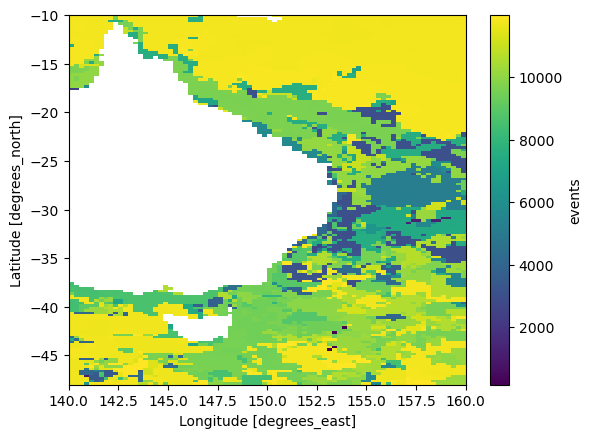

In [26]:
dur.idxmax(dim='events', skipna=True).plot()

In [27]:
# alternatively...
dur.where(dur==dur.max(), drop=True).squeeze()

<xarray.DataArray 'duration' ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lon      float64 157.9
    events   float64 1.174e+04
    lat      float64 -46.88
Attributes:
    long_name:  MHW duration in number of days
    units:      1

Right, so this has picked out the cell with the mhw max duration across the domain. Let's identify this cell relative to the overall domain

In [28]:
import cmocean as cm

In [29]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

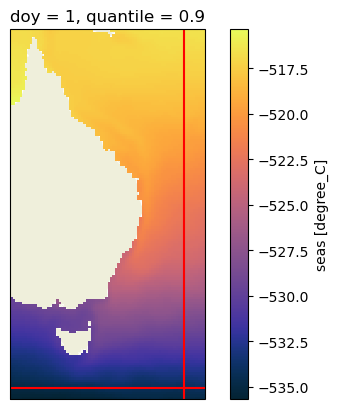

In [30]:
fig = plt.subplot(projection=ccrs.PlateCarree())
clim['seas'].isel(doy=0).plot(cmap=cm.cm.thermal, ax=fig)
plt.axhline(y=-46.88, color='r')
plt.axvline(x=157.9, color='r')
fig.add_feature(cfeature.LAND)

And when did this MHW take place, how long did it last?

In [31]:
dur_max = dur.where(dur==dur.max(), drop=True)
dur_max

<xarray.DataArray 'duration' (events: 1, lat: 1, lon: 1)>
dask.array<where, shape=(1, 1, 1), dtype=float64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 157.9
  * events   (events) float64 1.174e+04
  * lat      (lat) float64 -46.88
Attributes:
    long_name:  MHW duration in number of days
    units:      1

In [33]:
oisst_eac

<xarray.Dataset>
Dimensions:  (time: 12044, zlev: 1, lat: 152, lon: 80)
Coordinates:
  * lat      (lat) float32 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
  * lon      (lon) float32 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2023-03-23T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 152, 80), meta=np.ndarray>
Attributes: (12/40)
    CDI:                        Climate Data Interface version 2.0.5 (https:/...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    institution:                NOAA/National Centers for Environmental Infor...
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         oisst-avhrr-v02r01.19900101.nc
    ...                         ...
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    CDO:                        Climate Data Operators version 2.0.5 (https:/...
    NCO:                        netCDF Operators version 5.0.5 (Homepage = ht...
    history:                    Fri Sep 30 17:04:11 2022: ncatted -O -a histo...

In [81]:
sst = xr.open_dataset('/g/data/v45/jr5971/notebooks/data/oisst_eac.nc')
sst

<xarray.Dataset>
Dimensions:  (lat: 152, lon: 80, time: 12044, zlev: 1)
Coordinates:
  * lat      (lat) float32 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
  * lon      (lon) float32 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2023-03-23T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    sst      (time, zlev, lat, lon) float32 ...

In [82]:
sst.isel(time=int(dur_max.events.values))


<xarray.Dataset>
Dimensions:  (lat: 152, lon: 80, zlev: 1)
Coordinates:
  * lat      (lat) float32 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
  * lon      (lon) float32 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
    time     datetime64[ns] 2022-02-23T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    sst      (zlev, lat, lon) float32 ...

In [83]:
dur_max.values

array([[[275.]]])

So apparently this MHW started on 23rd Feb, 2022, and lasted for **275** days!

Let's now plot a time-series around this period for the that cell to see the how the temperature looked...

In [93]:
sst_max_dur = sst.sel(lat=dur_max.lat.values, lon=dur_max.lon.values, 
                      method='nearest').sel(time=slice('2010', '2020')).squeeze()['sst'] + 273.15

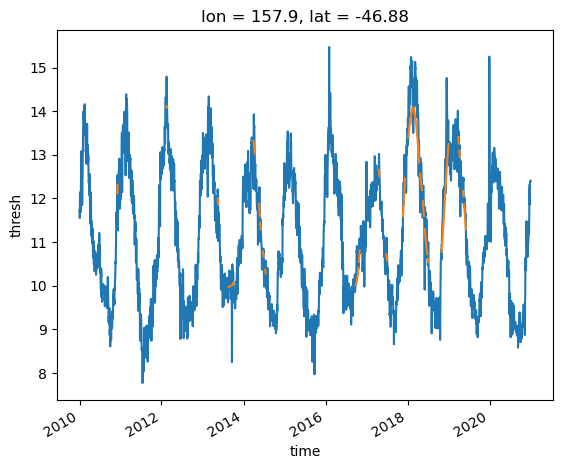

In [95]:
sst_max_dur.plot() 
int_ts.plot()

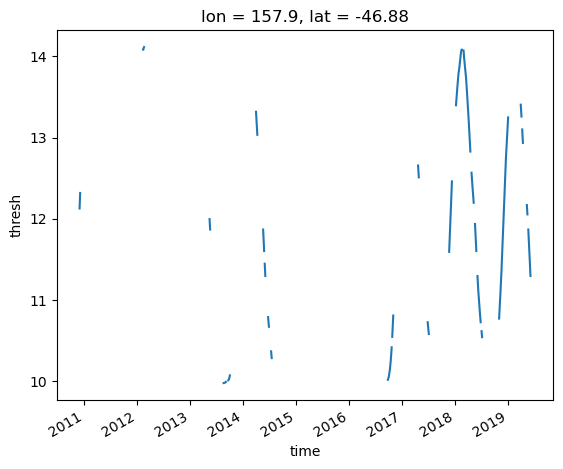

In [94]:
int_ts = interm['thresh'].sel(lat=dur_max.lat.values, lon=dur_max.lon.values, 
                      method='nearest').sel(time=slice('2010', '2020')).squeeze() + (2*273.15)
int_ts.plot()

Okay, so annoyingly the interm function has produced a heap of gaps in the time series for the climatology etc. 

If we say want to look at the 2015-16 MHW, let's just take the climatology from clim and put in on a separate x-axis. 

## plot the temperature for the various bioregions around Tasmania, along with their climatology...

1. Figure out which time series belong to the bioregions around Tasmania...

In [97]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon


In [98]:
# get bioregions
bioregs = gpd.read_file(
    '/g/data/v45/jr5971/notebooks/data/bioregions-IMCRA/imcra4_meso.shp'
)
bioregs

,MESO_NAME,MESO_NUM,MESO_ABBR,WATER_TYPE,AREA_KM2,geometry
0,Arafura,20,ARA,Tropical Waters,140371.226320,"POLYGON ((133.98098 -9.54585, 133.99146 -9.549..."
1,Torres Strait,9,TS,Transitional Waters,35627.224250,"POLYGON ((142.18087 -9.19609, 142.20628 -9.190..."
2,Oceanic Shoals,60,OSS,Transitional Waters,153880.151789,"POLYGON ((130.89500 -9.91979, 130.88510 -9.936..."
3,Ribbons,7,RBN,Transitional Waters,47804.709452,"POLYGON ((144.01321 -10.04215, 144.02174 -10.0..."
4,East Cape York,8,ECY,Transitional Waters,14427.641815,"POLYGON ((143.06360 -10.38830, 143.06811 -10.4..."
...,...,...,...,...,...,...
57,Boags,45,BGS,Cold Temperate Waters,8076.564645,"POLYGON ((144.64587 -40.25713, 144.69162 -40.2..."
58,Freycinet,48,FRT,Cold Temperate Waters,7947.917514,"POLYGON ((148.38129 -40.70045, 148.38249 -40.6..."
59,Franklin,57,FRA,Cold Temperate Waters,10361.951871,"POLYGON ((144.68779 -40.74937, 144.68820 -40.7..."
60,Bruny,47,BRU,Cold Temperate Waters,7278.438914,"POLYGON ((147.53393 -42.77710, 147.53642 -42.7..."


In [99]:
sst_bio = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/sst_spav.nc').rename('sst')
sst_bio = sst_bio.drop_duplicates(dim='bioregion')
sst_bio = sst_bio.drop_sel(bioregion='Victorian Embayments')
sst_bio

<xarray.DataArray 'sst' (time: 10592, bioregion: 59)>
[624928 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01T12:00:00 ... 2018-12-31T12:00:00
    lon        (bioregion) float64 ...
    lat        (bioregion) float64 ...
  * bioregion  (bioregion) object 'Arafura' 'Torres Strait' ... 'Bruny' 'Davey'
Attributes:
    regrid_method:  conservative

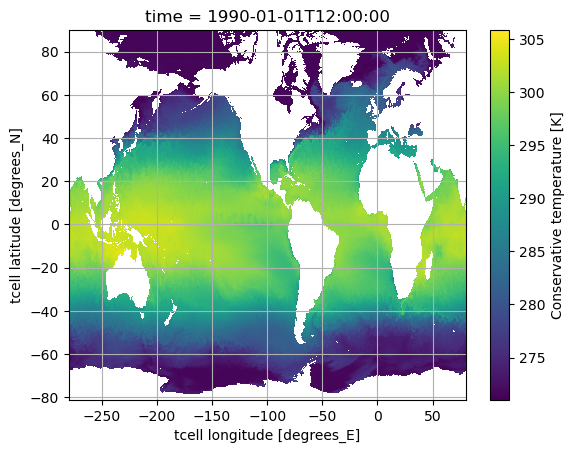

In [101]:
# get list of daily sst output from expt 01deg_jra55v140_iaf
ds_list = glob.glob('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output*/ocean/ocean-2d-surface_temp-1-daily-mean-ym_*.nc')
# Sort list and take files only after 1990
ds_list.sort()
newlist = []
newstart = 0
while 'ym_1990_' not in ds_list[newstart]:
    newstart+=1
newlist = ds_list[newstart:]
# Open dataset with the above files
ds = xr.open_mfdataset(newlist)
# Check domain coordinates before setting new boundaries
ds['surface_temp'].isel(time=0).plot()
plt.grid()

In [103]:
# rename coords of sst dataset
sst = sst.rename({'xt_ocean':'lon', 'yt_ocean':'lat'}) - 273.15
sst

<xarray.DataArray 'surface_temp' (time: 10592, lat: 469, lon: 550)>
dask.array<sub, shape=(10592, 469, 550), dtype=float32, chunksize=(92, 469, 550), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -254.9 -254.8 -254.7 -254.6 ... -200.2 -200.1 -200.0
  * lat      (lat) float64 -45.95 -45.88 -45.81 -45.74 ... -5.243 -5.143 -5.043
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2018-12-31T12:00:00

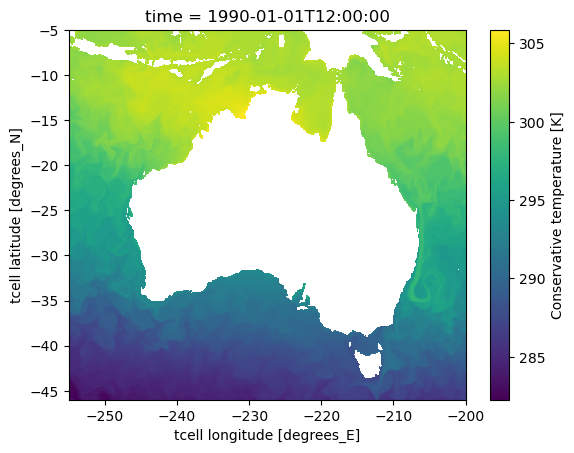

In [104]:
# Set new domain extent
aus_extent = {'W':-255, 'E':-200, 'S':-46, 'N':-5}
sst = ds['surface_temp'].sel(yt_ocean=slice(aus_extent['S'], aus_extent['N']),
                             xt_ocean=slice(aus_extent['W'], aus_extent['E']))
sst.isel(time=0).plot()

In [105]:
import cmocean as cm

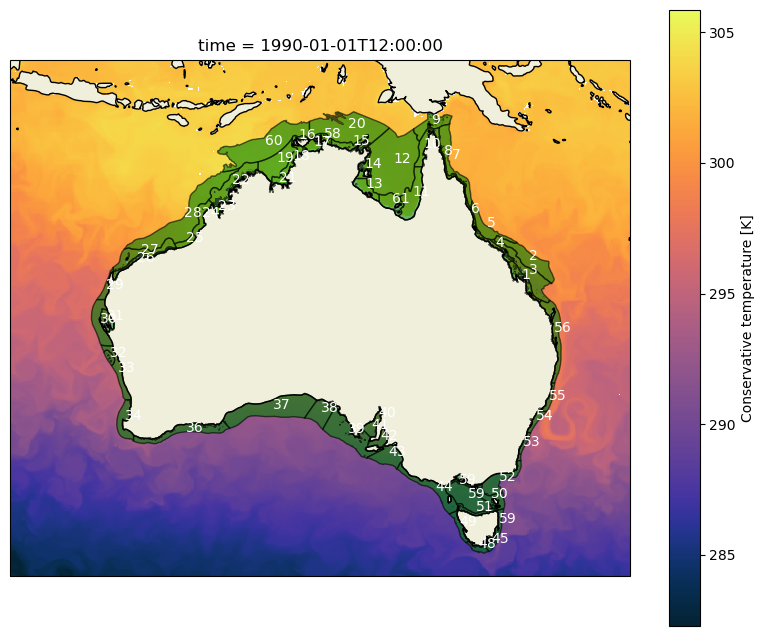

In [108]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
sst.isel(time=0).plot(ax=ax, cmap=cm.cm.thermal)
ax.add_feature(cfeature.LAND)
ax.coastlines()
bioregs.plot(ax=ax, edgecolor='k', facecolor='green', alpha=0.6)

for i in range(len(sst_bio.bioregion)):
    x = sst_bio.isel(bioregion=i).lon.values
    y = sst_bio.isel(bioregion=i).lat.values
    ax.text(x, y, s = str(bioregs.MESO_NUM[i]), c='white')


Right, so around Tassie, it looks like ...
* Bio-49 is on the west coast
* Bio-48 is on the south coast
* Bio 45 is in the Derwent
* Bio 59 takes up the east coast
* Bio 51 is the north coast
* Bio 50 is Flinders et al. 

Now, we can do various things with this - As an example, shall we look at the Tasman Fracture Marine Park? This would sit somewhere in bio 48. 

Let's pull up the time series for this one. And also the MHW results. BTW let's also do MHW results for NOAA

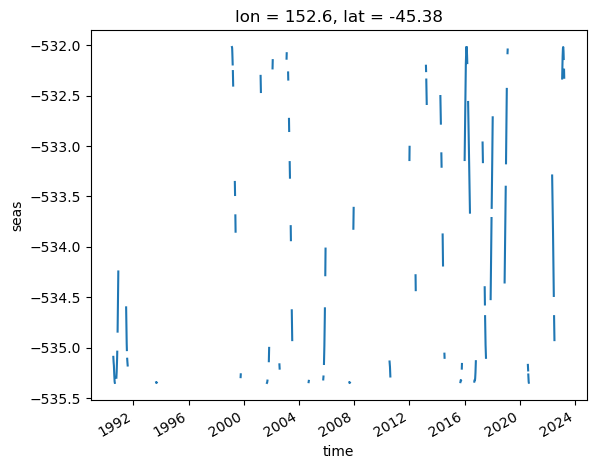

In [43]:
interm['seas'][:,10,50].plot()

In [41]:
seas = doy_rep['seas']
seas_max_dur = seas.sel(lat=dur_max.lat.values, lon=dur_max.lon.values, 
                      method='nearest').sel(time=slice('2021', '2023')).squeeze()
seas_max_dur

<xarray.DataArray 'seas' (time: 790)>
dask.array<getitem, shape=(790,), dtype=float32, chunksize=(790,), chunktype=numpy.ndarray>
Coordinates:
    lon       float32 157.9
    doy       (time) int64 1 2 3 4 5 6 7 8 9 10 ... 52 53 54 55 56 57 58 59 60
    lat       float32 -46.88
    quantile  float64 0.9
  * time      (time) object 2021-01-01 00:00:00 ... 2023-03-01 00:00:00
Attributes:
    units:    degree_C

In [49]:
len(time)

718

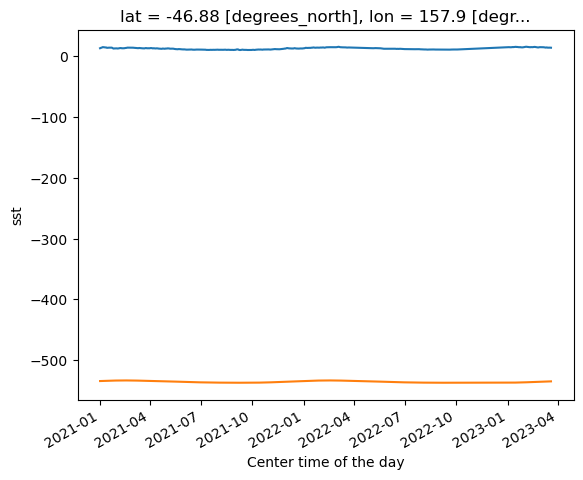

In [55]:
(sst_max_dur + 274.15).plot()
plt.plot(time, seas_max_dur[:len(time)])

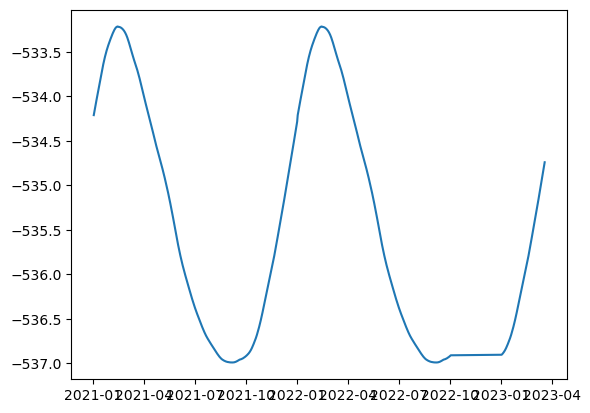

In [52]:
time = sst_max_dur.time
plt.plot(time, seas_max_dur[:len(time)])
# plt.plot(time, sst_max_dur)

In [39]:
clim_rep = doy_rep
clim_max = clim_rep.sel(lat=dur_max.lat.values, lon=dur_max.lon.values, 
                      method='nearest').sel(time=slice('2021', '2023')).squeeze()
clim_max['seas'].plot()
sst_max_dur.plot()

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x153c651c6040> (for post_execute):


TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

<Figure size 640x480 with 1 Axes>

In [22]:
# get dates from sst data
time = sst.time


In [31]:
time_ = xr.cftime_range('1990-01-01', '2023-03-01')

days = time_.dayofyear

In [33]:
selector = xr.DataArray(days, dims=['time'], 
                        coords=[time_])
selector

<xarray.DataArray (time: 12113)>
array([ 1,  2,  3, ..., 58, 59, 60])
Coordinates:
  * time     (time) object 1990-01-01 00:00:00 ... 2023-03-01 00:00:00

In [34]:
doy_rep = clim.sel(doy=selector)

In [35]:
doy_rep

<xarray.Dataset>
Dimensions:   (lon: 80, time: 12113, lat: 152)
Coordinates:
  * lon       (lon) float32 140.1 140.4 140.6 140.9 ... 159.1 159.4 159.6 159.9
    doy       (time) int64 1 2 3 4 5 6 7 8 9 10 ... 52 53 54 55 56 57 58 59 60
  * lat       (lat) float32 -47.88 -47.62 -47.38 -47.12 ... -10.62 -10.38 -10.12
    quantile  float64 0.9
  * time      (time) object 1990-01-01 00:00:00 ... 2023-03-01 00:00:00
Data variables:
    thresh    (time, lat, lon) float64 dask.array<chunksize=(12113, 4, 80), meta=np.ndarray>
    seas      (time, lat, lon) float32 dask.array<chunksize=(12113, 4, 80), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2023-03-23: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

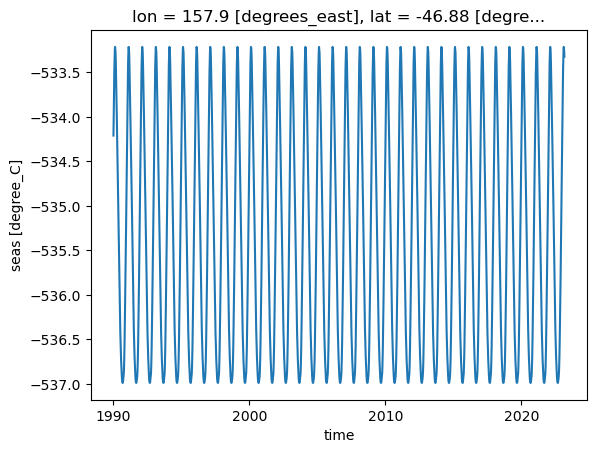

In [36]:
doy_rep['seas'].sel(lat=dur_max.lat.values, lon=dur_max.lon.values, method='nearest').plot()

In [27]:
time[0]

<xarray.DataArray 'time' ()>
array('1990-01-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1990-01-01T12:00:00
Attributes:
    standard_name:  time
    long_name:      Center time of the day
    axis:           T